In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, IBMQ, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.tools import job_monitor

from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import Optimizer, SLSQP, SPSA
from qiskit.opflow.gradients import GradientBase
from qiskit.quantum_info import Pauli, Operator

from qiskit.providers.fake_provider import FakeMumbai
from qiskit.compiler import transpile
import qiskit

import numpy as np
from skquant.opt import minimize
from scipy.stats import pearsonr
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import pickle
import copy
import csv

from VarSaw.term_grouping import *
import VarSaw.Reconstruction_Functions as RF

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler
from qiskit_aer.noise import NoiseModel

In [2]:
# choose the runtime service sampler backend

service = QiskitRuntimeService(channel="ibm_quantum")
backend_string = "ibmq_qasm_simulator" #alter the name of the backend here
backend = service.backend(backend_string)
sampler = Sampler(backend = backend)

In [ ]:
options = Options()
options.execution.shots = 8192
options.optimization_level = 3 # dynamical decoupling
options.resilience_level = 1 # T-rex (assume nothing about the noise)

# the resilience_level flag can potentially be tuned if we infer
# something about the device noise

In [3]:
#################### Function to get Pauli strings and Coefficients from the parsed hamiltonian #####################
def give_paulis_and_coeffs(hamiltonian, num_qubits):
    '''
    hamiltonian: A list containing all hamiltonian terms along with their weights
    num_qubits: The number of qubits in the hamiltonian
    '''
    paulis = []
    coeffs = []
    
    for idx, term in enumerate(hamiltonian):
        
        #the coefficient
        coeffs.append(term[0])
        
        #the pauli string
        pauli_string = num_qubits*'I'
        all_gates = term[1]
        #print(non_id_gates)
        
        for _, gate in enumerate(all_gates):
            pauli = gate[0]
            location = int(gate[1])
            #print('location: ', location, 'pauli_string: ', pauli_string, 'pauli: ', pauli)
            pauli_string = pauli_string[0:location] + pauli + pauli_string[location+1:]
            #print(pauli_string, len(pauli_string))
        
        paulis.append(pauli_string)
    
    return coeffs, paulis

##################### Function to create parameterized quantum state ################################
def quantum_state_preparation(circuit, parameters):
    '''
    Args:
    circuit: The input circuit to which we append the parameterized state
    parameters: The parameters of the rotations
    
    Returns:
    Circuit with /home/siddharthdangwal/JigSaw+VQE/Data/Experiment 2/TFIM-4-full/noisy_jigsaw_params.csvthe ansatz for a generalized state appended to it
    '''
    num_qubits = circuit.num_qubits
    
    #the number of repetitions of a general ansatz block
    p = (len(parameters)/(2*num_qubits)) - 1
    
    #make sure that p is an integer and then change the format
    assert int(p) == p
    p = int(p)
    
    #create an EfficientSU2 ansatz
    ansatz = EfficientSU2(num_qubits = num_qubits, entanglement = 'full', reps = p, insert_barriers = True)
    ansatz.assign_parameters(parameters = parameters, inplace = True)
    circuit.compose(ansatz, inplace = True)
    
    return circuit

##################### Prepare a VQE circuit for a given single-element hamiltonian ################################
def vqe_circuit(n_qubits, parameters, hamiltonian):
    '''
    Args:
    n_qubits: The number of qubits in the circuit
    parameters: The parameters for the vqe circuit
    hamiltonian: The hamiltonian string whose expectation would be measured
    using this circuit
    
    Returns:
    The VQE circuit for the given Pauli tensor hamiltonian 
    '''
    from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
    
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    
    #append the circuit with the state preparation ansatz
    circuit = quantum_state_preparation(circuit, parameters)
    
    #add the measurement operations
    for i, el in enumerate(hamiltonian):
        if el == 'I':
            #no measurement for identity
            continue
        elif el == 'Z':
            circuit.measure(qr[i], cr[i])
        elif el == 'X':
            circuit.u(np.pi/2, 0, np.pi, qr[i])
            circuit.measure(qr[i], cr[i])
        elif el == 'Y':
            circuit.u(np.pi/2, 0, np.pi/2, qr[i])
            circuit.measure(qr[i], cr[i])
    
    return circuit

############################# Functions to generate marginal Paulis (with or without repeated terms) ###########################
def generate_marginal_paulis(paulis, meas_size):
    '''
    Args:
    paulis:
    meas_size:
    
    Returns: All marginal paulis. Eliminates repeated terms
    
    '''
    marginal_paulis = []
    length_pauli = len(paulis[0])
    
    for idx, el in enumerate(paulis):
        for i in range(length_pauli - meas_size + 1):
            marginal = i*'I' + el[i:i+meas_size] + (length_pauli - i - meas_size)*'I'
            if marginal not in marginal_paulis:
                marginal_paulis.append(marginal)
    
    return marginal_paulis

def generate_marginal_paulis2(paulis, meas_size):
    '''
    Args:
    paulis:
    meas_size:
    
    Returns: All marginal paulis. Does not eliminate repeated terms
    
    '''
    marginal_paulis = []
    length_pauli = len(paulis[0])
    
    for idx, el in enumerate(paulis):
        for i in range(length_pauli - meas_size + 1):
            marginal = i*'I' + el[i:i+meas_size] + (length_pauli - i - meas_size)*'I'
            marginal_paulis.append(marginal)
    
    return marginal_paulis
    
####################################### Functions to perform bayesian reconstruction of the main distribution using marginals ############################################
def bayesian_reconstruction(main_dist, marginal_dists, max_recur_count):
    '''
    Args:
    main_dist: The main distribution that needs to be changed
    marginal_dists: A dictionary of marginal distributions, where the key is the hamiltonian of the marginal
    max_recur_count: Maximum number of times the reconstruction function needs to be called
    
    Returns:
    The bayesian reconstructed output
    '''
    
    _baseline = copy.deepcopy(main_dist)
    _partials = copy.deepcopy(marginal_dists)
    
    reconstructed = reconstruct(_baseline, _partials)
    
    for i in range(max_recur_count):
        _baseline = [reconstructed]
        reconstructed = reconstruct(_baseline[0], _partials)
        if RF.Compute_Helinger(_baseline[0], reconstructed) < 0.0001:
            break
        
    return reconstructed

def reconstruct(main_dist, marginal_dists):
    '''
    Args:
    main_dist: The main distribution that needs to be changed
    marginal_dists: A dictionary of marginal distributions, where the key is the hamiltonian of the marginal
    
    Returns:
    The result of one iteration of bayesian update
    '''
    #normalize the main dictionary
    pout = RF.normalize_dict(copy.deepcopy(main_dist))
    
    for hamil in marginal_dists:
        ppost = bayesian_update(main_dist, RF.normalize_dict(marginal_dists[hamil]), hamil)
        pout = add_dists(ppost, pout)
        pout = RF.normalize_dict(pout)
    
    return pout

def add_dists(d1, d2):
    '''
    Args:
    d1: dictionary 1 
    d2: dictionary 2
    
    Returns:
    The sum of the two dictioanies
    '''
    updated_dict = {}
    
    keys = set(list(d1.keys()) + list(d2.keys()))
    all_values_sum = sum(list(d1.values())) + sum(list(d2.values()))
    
    for key in keys:
        if key in d1.keys() and key not in d2.keys():
            updated_dict[key] = d1[key]/all_values_sum
        elif key in d2.keys() and key not in d1.keys():
            updated_dict[key] = d2[key]/all_values_sum
        else:
            updated_dict[key] = (d2[key] + d1[key])/all_values_sum
    
    return updated_dict

def bayesian_update(main_dist, marginal_dist, hamil):
    '''
    Args:
    main_dist: The main distribution that needs to be changed
    marginal_dists: A dictionary of marginal distributions, where the key is the hamiltonian of the marginal
    hamil: The hamiltonian corresponding to the marignal_dist
    '''
    
    #track the location of 
    i_locs = []
    length = len(hamil)
    for idx, el in enumerate(hamil):
        if el != 'I':
            i_locs.append(length - idx - 1)
    
    #sort i_locs
    i_locs.sort()
    
    #created an updated marginal dict
    updated_marginal = {}
    marginal_keys = list(marginal_dist.keys())
    processed_keys = set() #the set of processed marginal keys
    
    for idx, key in enumerate(marginal_keys):
        if key in processed_keys:
            continue
        else:
            processed_keys.add(key)
            track_object = ''.join(list(np.array(list(key))[i_locs]))
            val = marginal_dist[key]
            processed_keys, extra_val = marginalize(marginal_dist, marginal_keys[idx+1:], track_object, processed_keys, i_locs)
            updated_marginal[track_object] = val + extra_val
    
    #print('updated marginal: ', updated_marginal)
    
    #now update the main dict
    updated_main_dict = copy.deepcopy(main_dist)
    for pry in updated_marginal:
        candidates = []
        running_sum = 0
        for prx in main_dist:
            if ''.join(list(np.array(list(prx))[i_locs])) == pry:
                running_sum += main_dist[prx]
                candidates.append([main_dist[prx], prx])
    
        for idx, el in enumerate(candidates):
            normalized_val = el[0]/running_sum
            updated_value = (normalized_val*updated_marginal[pry])/(1 - updated_marginal[pry])
            updated_main_dict[el[1]] = updated_value
    
    #normalize updated_main_dict
    updated_main_dict = RF.normalize_dict(updated_main_dict)
    
    return updated_main_dict

def marginalize(marginal_dict, keys, track_object, processed_keys, locs):
    '''
    Args:
    marginal_dict: The marginal dictionary
    relevant_keys: The potential candidates
    track_object: The relevant substring of the reference key
    processed_keys: a dictionary keeping track of which keys have been processed
    locs: Locations to trace similarity
    
    Returns:
    
    '''
    extra_val = 0
    for key in keys:
        if track_object == ''.join(list(np.array(list(key))[locs])):
            extra_val += marginal_dict[key]
            processed_keys.add(key)
    
    return processed_keys, extra_val
    
################################## Compute the expectation of the hamiltonian with JigSaw ############################## 
def compute_expectations_with_jigsaw(parameters, paulis, shots, meas_size, backend, mode, opt_level, external_dists = None, dict_filename = None, seed = 0):
    '''
    Args:
    parameters: The parameters of the VQE ansatz
    paulis: The paulis tensor hamiltonians
    backend: The backend on which the vqe is run
    mode: Specifies if we have to run a noisy simulation or ideal simulation or run the circuit on a device
    shots: The total shots budget
    meas_size: An integer specifying the number of terms each new pauli hamiltonian consists of
    external_dists: A dictionary containing distributions for each term in the hamiltonian. If none, then compute
    the distributions, else use the ones given in external_dist
    
    Returns:
    expectations: A list of expectations for each circuit
    reconstructed_counts: A list of counts of the reconstructed circuit
    '''
    
    #get the new marginal paulis
    marginal_paulis = generate_marginal_paulis(paulis, meas_size)
    #print('Number of marginal paulis: ', len(marginal_paulis))
    
    #the number of qubits in the ansatz
    n_qubits = len(paulis[0])
    
    #get all the original vqe circuits
    if external_dists == None:
        circuits = [vqe_circuit(n_qubits, parameters, pauli) for pauli in paulis]

    #get all the marginal vqe circuits
    marginal_circuits = [vqe_circuit(n_qubits, parameters, hamil) for hamil in marginal_paulis]
    marginal_circuits = {k:v for k, v in zip(marginal_paulis, marginal_circuits)}
    
    sim_device = None
    if mode == 'noisy_sim':
        noise_model = NoiseModel.from_backend(backend)
        options = Options()
        options.simulator = {
            "noise_model": noise_model,
            "basis_gates": backend.basis_gates,
            "coupling_map": backend.configuration().coupling_map,
            "seed_simulator" : 
        }
        sampler = Sampler(options=options)
    
    #evaluate the original circuits
    if external_dists == None:
        if mode == 'no_noisy_sim' or mode == 'device_execution':
            job = execute(circuits, backend = backend, optimization_level = 3, shots = 8192)
            all_counts = job.result().get_counts()
            options = Options()
            options. = # add options here
            sampler = Sampler(backend = backend, options = options)
            probs = sampler.run(circuits)
            
        elif mode == 'noisy_sim':
            tcircs = transpile(circuits, sim_device, optimization_level = 3)
            result_noise = sim_device.run(tcircs, shots = 8192).result()
            #all_counts = result_noise.get_counts()
            all_counts = []
            for __, _id in enumerate(paulis):
                if _id == len(_id)*'I':
                    all_counts.append({len(_id)*'0':8192})
                else:
                    all_counts.append(result_noise.get_counts(__))
            probs = sampler.run(circuits)
            options = Options()
            options. = # add options here
            sampler = Sampler(backend = backend, options = options)
            probs = []
            for __, _id in enumerate(paulis):
                if _id == len(_id)*'I':
                    probs.append({len(_id)*'0':8192})
                else:
                    probs.append(probs.get_counts(__)) # get the count number
                
            
        else:
            raise Exception('Invalid circuit execution mode')
    
    #evaluate all the marginal circuits
    if mode == 'no_noisy_sim' or mode == 'device_execution':
        job = execute(list(marginal_circuits.values()), backend = backend, shots = 8192, optimization_level = 3)
        all_marginal_counts = job.result().get_counts()
    elif mode == 'noisy_sim':
        tcircs = transpile(list(marginal_circuits.values()), sim_device, optimization_level = 3)
        result_noise = sim_device.run(tcircs, shots = 8192).result()
        #all_marginal_counts = result_noise.get_counts()
        all_marginal_counts = []
        for __, _id in enumerate(marginal_paulis):
            if _id == len(_id)*'I':
                all_marginal_counts.append({len(_id)*'0':8192})
            else:
                all_marginal_counts.append(result_noise.get_counts(__))
    else:
        raise Exception('Invalid circuit execution mode')
    
    all_marginal_counts = {k:v for k, v in zip(marginal_paulis, all_marginal_counts)}
    
    #reconstruct the original distributions
    reconstructed_counts = []
    for idx, pauli in enumerate(paulis):
        relevant_marginals = generate_marginal_paulis([pauli], meas_size)
        relevant_marginal_counts = {}
        for marginal in relevant_marginals:
            relevant_marginal_counts[marginal] = all_marginal_counts[marginal]
        
        if external_dists == None:
            reconstructed_counts.append(bayesian_reconstruction(all_counts[idx], relevant_marginal_counts, max_recur_count = 10))
        else:
            reconstructed_counts.append(bayesian_reconstruction(external_dists[idx], relevant_marginal_counts, max_recur_count = 10))
    
    #dump the reconstructed counts
    #pickle.dump(reconstructed_counts, open(dict_filename[:-4] + '_seed_' + str(seed) + '_global_opt_level_' + str(opt_level) + '_iter_num_' + str(iter_num) + '.pkl', 'wb'))
    #iter_num += 1

    #compute the expectations
    expectations = []
    
    for i, count in enumerate(reconstructed_counts):
        
        #initiate the expectation value to 0
        expectation_val = 0
        
        #compute the expectation
        for el in count.keys():
            sign = 1
            
            #change sign if there are an odd number of ones
            if el.count('1')%2 == 1:
                sign = -1
            
            expectation_val += sign*count[el]
        
        expectations.append(expectation_val)
    
    return expectations, reconstructed_counts

########################################## Compute VQE loss ###################################################### 
def compute_loss_with_jigsaw(parameters, paulis, coeffs, shots, meas_size, backend, mode, opt_level, external_dists, dict_filename = None, seed = 0):
    '''
    Args:
    parameters: The parameters of the VQE ansatz
    paulis: The paulis tensor hamiltonians
    coeffs: The coefficients corresponding to each pauli tensor
    backend: The backend on which the vqe is run
    mode: Specifies if we have to run a noisy simulation or ideal simulation or run the circuit on a device
    shots: The number of shots for which each circuit is executed
    external_dists: A dictionary containing distributions for each term in the hamiltonian. If none, then compute
    the distributions, else use the ones given in external_dist
    
    Returns:
    The loss for the entire VQE hamiltonian
    '''
    
    expectations, reconstructed_counts = compute_expectations_with_jigsaw(parameters, paulis,  shots, meas_size, backend, mode, opt_level, external_dists = external_dists, dict_filename = dict_filename, seed = seed)
    
    loss = 0
    
    for i, el in enumerate(expectations):
        loss += coeffs[i]*el
    
    return loss, reconstructed_counts

####################################################### VQE function ###################################################################
def vqe_with_jigsaw(parameters, paulis, coeffs, shots, meas_size, backend, external_dists = None, mode = 'no_noisy_sim', opt_level = 1, loss_filename = None, params_filename = None, dict_filename = None, seed = 0):
    '''
    Args:
    parameters: The parameters of the VQE ansatz
    paulis: The paulis tensor hamiltonians
    coeffs: The coefficients corresponding to each pauli tensor
    backend: The backend on which the vqe is run
    external_dists: A dictionary containing distributions for each term in the hamiltonian. If none, then compute
    the distributions, else use the ones given in external_distA dictionary containing distributions for each term in the hamiltonian. If none, then compute
    the distributions, else use the ones given in external_dist
    mode: Specifies if we have to run a noisy simulation or ideal simulation or run the circuit on a device
    shots: The number of shots for which each circuit is executed
    
    Returns:
    Loss for one iteration of the A dictionary containing distributions for each term in the hamiltonian. If none, then compute
    the distributions, else use the ones given in external_distVQE
    '''
    
    #number of qubits in the VQE ansatz
    n_qubits = len(paulis[0])
    
    #making sure that the number of elements in each pauli tensor is the same
    for i in paulis:
        assert len(i) == n_qubits
    
    loss, reconstructed_counts =  compute_loss_with_jigsaw(parameters, paulis, coeffs, shots, meas_size, backend, mode, opt_level, external_dists = external_dists, dict_filename = dict_filename, seed = seed)
    #print('Loss computed by VQE is: {}'.format(loss))

    return loss,reconstructed_counts

############################# Wrapper Function to compute VQE with JigSaw where the distribution from the previous iteration is reused ###########################
def vqe_with_jigsaw_wrapper(parameters, paulis, coeffs, shots, meas_size, backend, mode = 'noisy_sim', opt_level = 1, loss_filename = None, params_filename = None, dict_filename = None, seed = 0):
    
    #get the reconstructed counts and the loss value
    global external_dists
    loss, reconstructed_counts = vqe_with_jigsaw(parameters, paulis = paulis, coeffs = coeffs, shots = shots_dev, meas_size = meas_size, backend = backend, external_dists = external_dists, mode = mode, opt_level = opt_level, loss_filename = loss_filename, params_filename = params_filename, dict_filename = dict_filename, seed = seed)
    external_dists = reconstructed_counts
    
    return loss

SyntaxError: expression expected after dictionary key and ':' (54850666.py, line 318)

In [4]:
def callback_function(nfev, x_next, fx_next, norm, boolean, opt_level, loss_list = None, params_list = None, loss_filename = None, params_filename = None, paulis = None, coeffs = None, device = None, seed = None):
    '''
    Args:
    We do not need to worry about any other argument except:
    1)x_next: The parameter value
    2)fx_next: The value of the function
    3)loss_list: A global list in which we store the values of losses that the callback function prints
    4)loss_filename: The name of the file where the loss is stored
    5)params_filename: The name of the file where the params are stored
    
    Returns:
    Prints loss and parameters and saves them in a file
    '''
    
    global current_iteration
    global external_dists
    global init_switch_shots
    global recurring_switch_shots

    if opt_level == 5:
        #this flag determines which loss should the vqe_with_jigsaw_opt5_function return
        #if this flag is 0, then it returns the external dists loss. If this flag is 1, 
        #it returns the no-extneral dists loss
        global external_dists_flag
        
        #Print the loss and parameters
        print('The loss value at iteration number ', current_iteration, ' is: ', fx_next)
        #print('The parameters are: ', x_next)

        if (current_iteration + 1)%recurring_switch_shots == 0 and (current_iteration + 1) >= init_switch_shots:
            #compute the loss with global computed
            loss1, reconstructed_counts1 = vqe_with_jigsaw(x_next, paulis = paulis, coeffs = coeffs, shots = 8192, meas_size = 2, backend = device, external_dists = None, mode = 'noisy_sim', opt_level = 1, loss_filename = None, params_filename = None, dict_filename = None, seed = seed) #with no external dists
            #compare the losses
            if loss1 < fx_next:
                #recomputing global helps
                recurring_switch_shots = max(10, int(recurring_switch_shots//2))
                external_dists = reconstructed_counts1
                print('Computed global and it improved the performance. We will compute it more frequently now.')
                external_dists_flag = 1

                #save the loss
                if not (loss_list == None):
                    loss_list.append(loss1)

                if not (loss_filename == None):
                    with open(loss_filename, 'a') as file:
                        writer = csv.writer(file)
                        writer.writerow([loss1])

            else:
                recurring_switch_shots = int(recurring_switch_shots*2)
                print('Computed global and it did not improve the performance. We will compute it less frequently now.')
                external_dists_flag = 0
                
                #save the loss
                if not (loss_list == None):
                    loss_list.append(fx_next)

                if not (loss_filename == None):
                    with open(loss_filename, 'a') as file:
                        writer = csv.writer(file)
                        writer.writerow([fx_next])
    else:
        #save the loss
        if not (loss_list == None):
            loss_list.append(fx_next)

        if not (loss_filename == None):
            with open(loss_filename, 'a') as file:
                writer = csv.writer(file)
                writer.writerow([fx_next])

    #store params in the list
    if not (params_list == None):
        params_list.append(x_next)
    
    if not(params_filename == None):
        with open(params_filename, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(x_next)
    
    current_iteration += 1
    
    return 

In [ ]:
tol = 1e-5

simulator = Aer.get_backend('qasm_simulator')
device = FakeMumbai()

shots_sim = 8192
shots_dev = 8192

#get the seed as the first argument
seed = int(0)
np.random.seed(seed)
qiskit.utils.algorithm_globals.random_seed = seed

p = 2

#get the optimization level
opt_level = int(1)

#get the system hamiltonian
hamiltonian_string = '/Users/sid/Internship Project/VarSaw/vqe-term-grouping-master/hamiltonians/CH4_sto-3g_BK_grnd_AS3.txt'
hamiltonian_string_elements = hamiltonian_string.split('/')
hamil = parseHamiltonian(hamiltonian_string)

#get the number of qubits in the hamiltonian
max_length = 0
for i in hamil:
    if int(i[1][-1][1]) + 1 > max_length:
        max_length = int(i[1][-1][1]) + 1

#Number of qubits in the hamiltonian
n_qubits = max_length

#get paulis and coefficients
coeffs, paulis = give_paulis_and_coeffs(hamil, n_qubits)

#define optimizer bounds, initial_point and budget
bounds = np.array([[0, np.pi*2]]*2*n_qubits*(p+1))
initial_point = np.array([np.pi]*2*n_qubits*(p+1))

#initiate the iteration number
global current_iteration
current_iteration = 0

#get the vqe result
if opt_level == 1:

    loss_filename = hamiltonian_string_elements[-1] + '_vqe_with_jigsaw_opt1_loss_' + sys.argv[1] + '.csv'
    params_filename = hamiltonian_string_elements[-1] + '_vqe_with_jigsaw_opt1_params_' + sys.argv[1] + '.csv'
    callback_func = lambda a, b, c, d, e: callback_function(a, b, c, d, e, opt_level = 1, loss_filename = loss_filename, params_filename = params_filename)
    
    #define the spsa optimizer
    spsa = SPSA(maxiter = 1000, callback = callback_func)

    global_dict_name_prefix = hamiltonian_string_elements[-1]
    
    #we do not write to a file in the objective function now. Writing to file happens in the callback function
    objective_function = lambda c:vqe_with_jigsaw(c, paulis = paulis, coeffs = coeffs, shots = shots_dev, meas_size = 2, backend = device, external_dists = None, mode = 'noisy_sim', opt_level = 1, loss_filename = loss_filename, params_filename = params_filename, dict_filename = global_dict_name_prefix, seed = seed)[0]
    vqe_result_jigsaw = spsa.optimize(num_vars = 2*n_qubits*(p+1), objective_function = objective_function, variable_bounds = bounds, initial_point = initial_point)

elif opt_level == 2:

    loss_filename = hamiltonian_string_elements[-1] + '_vqe_with_jigsaw_opt2_loss_' + sys.argv[1] + '.csv'
    params_filename = hamiltonian_string_elements[-1] + '_vqe_with_jigsaw_opt2_params_' + sys.argv[1] + '.csv'
    callback_func = lambda a, b, c, d, e: callback_function(a, b, c, d, e, opt_level = 2, loss_filename = loss_filename, params_filename = params_filename)
    
    #define the spsa optimizer
    spsa = SPSA(maxiter = 1000, callback = callback_func)

    global_dict_name_prefix = hamiltonian_string_elements[-1]

    #first iteration normally
    loss, reconstructed_counts = vqe_with_jigsaw(initial_point, paulis = paulis, coeffs = coeffs, shots = shots_dev, meas_size = 2, backend = device, external_dists = None, mode = 'noisy_sim', opt_level = 2, loss_filename = loss_filename, params_filename = params_filename, dict_filename = global_dict_name_prefix, seed = seed)
    external_dists = reconstructed_counts

    #converge second iteration onwards
    objective_function = lambda c:vqe_with_jigsaw_wrapper(c, paulis = paulis, coeffs = coeffs, shots = shots_dev, meas_size = 2, backend = device, mode = 'noisy_sim', opt_level = 2, loss_filename = loss_filename, params_filename = params_filename, dict_filename = global_dict_name_prefix, seed = seed)
    vqe_result_jigsaw = spsa.optimize(num_vars = 2*n_qubits*(p+1), objective_function = objective_function, variable_bounds = bounds, initial_point = initial_point)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler, Options
from qiskit_aer.noise import NoiseModel

In [ ]:
c1 = QuantumCircuit(2, 2)
c1.h(0)
c1.cx(0, 1)
c1.measure([0, 1], [0, 1])

c2 = QuantumCircuit(3, 3)
c2.h(0)
c2.cx(0, 1)
c2.ccx(0, 1, 2)
c2.x(2)
c2.measure([0, 1, 2], [0, 1, 2])

all_circs = [c1, c2]

In [ ]:
from qiskit_ibm_provider import IBMProvider
ibm_provider = IBMProvider()
device_backend = ibm_provider.get_backend('ibmq_mumbai')

In [ ]:
noise_model = NoiseModel.from_backend(device_backend)

options1 = Options()
options1.simulator = {
    "noise_model": noise_model,
    "basis_gates": backend.basis_gates,
    "coupling_map": backend.configuration().coupling_map,
    "seed_simulator" : 0
}
options1.resilience_level = 1

options2 = Options()
options2.simulator = {
    "noise_model": noise_model,
    "basis_gates": backend.basis_gates,
    "coupling_map": backend.configuration().coupling_map,
    "seed_simulator" : 0
}
options2.resilience_level = 0

In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend_string = "ibmq_qasm_simulator" #alter the name of the backend here
backend = service.backend(backend_string)
sampler1 = Sampler(backend = backend)
sampler2 = Sampler(backend = backend, options = options1)
sampler3 = Sampler(backend = backend, options = options2)

In [ ]:
job1 = sampler1.run(all_circs)
job2 = sampler2.run(all_circs)
job3 = sampler3.run(all_circs)

result1 = job1.result()
result2 = job2.result()
result3 = job3.result()

In [ ]:
result1.quasi_dists[0]

In [ ]:
result2.quasi_dists[0]

In [ ]:
result3.quasi_dists[0]

### Mitiq testing ###

In [5]:
import qiskit
from qiskit_ibm_provider import IBMProvider

import mitiq
from mitiq import zne
from mitiq.zne.inference import RichardsonFactory

In [6]:
USE_REAL_HARDWARE = True

In [7]:
def compute_expectations(all_counts):
    '''
    Args:
    all_counts: All the counts for which we want to compute expectations
    
    Returns:
    All the expectation values
    
    '''
    all_expectation_vals = []
    for idx, count in enumerate(all_counts): 
        sum_counts = sum(list(count.values()))
        exp_val = 0
        for el in count:
            
            # allot the sign to the element
            sign = 1
            if el.count('1')%2 == 1:
                sign = -1
            
            # add to expectation value
            exp_val += sign*(count[el]/sum_counts)
        
        all_expectation_vals.append(exp_val)
            
    return all_expectation_vals

####################################################################################################################
def get_ref_energy(coeffs, paulis):
    '''
    Args:
    coeffs: The coeffs of the puali tensor products
    paulis: The pauli tensors
    '''   
    # the final operation
    final_op = None

    for ii, el in enumerate(paulis):
        if ii == 0:
            final_op = coeffs[ii]*Operator(Pauli(el))
        else:
            final_op += coeffs[ii]*Operator(Pauli(el))
   
    # compute the eigenvalues
    evals, evecs = eigh(final_op.data)
   
    # get the minimum eigenvalue
    min_eigenval = np.min(evals)
    return min_eigenval

###################################################################################################################
def give_paulis_and_coeffs(hamiltonian, num_qubits):
    '''
    hamiltonian: A list containing all hamiltonian terms along with their weights
    num_qubits: The number of qubits in the hamiltonian
    '''
    paulis = []
    coeffs = []
    
    for idx, term in enumerate(hamiltonian):
        
        #the coefficient
        coeffs.append(term[0])
        
        #the pauli string
        pauli_string = num_qubits*'I'
        all_gates = term[1]
        #print(non_id_gates)
        
        for _, gate in enumerate(all_gates):
            pauli = gate[0]
            location = int(gate[1])
            #print('location: ', location, 'pauli_string: ', pauli_string, 'pauli: ', pauli)
            pauli_string = pauli_string[0:location] + pauli + pauli_string[location+1:]
            #print(pauli_string, len(pauli_string))
        
        paulis.append(pauli_string)
    
    return coeffs, paulis

##################### Function to create parameterized quantum state ################################
def quantum_state_preparation(circuit, parameters):
    '''
    Args:
    circuit: The input circuit to which we append the parameterized state
    parameters: The parameters of the rotations
    
    Returns:
    Circuit with /home/siddharthdangwal/JigSaw+VQE/Data/Experiment 2/TFIM-4-full/noisy_jigsaw_params.csvthe ansatz for a generalized state appended to it
    '''
    num_qubits = circuit.num_qubits
    
    #the number of repetitions of a general ansatz block
    p = (len(parameters)/(2*num_qubits)) - 1
    
    #make sure that p is an integer and then change the format
    assert int(p) == p
    p = int(p)
    
    #create an EfficientSU2 ansatz
    ansatz = EfficientSU2(num_qubits = num_qubits, entanglement = 'full', reps = p, insert_barriers = True)
    ansatz.assign_parameters(parameters = parameters, inplace = True)
    circuit.compose(ansatz, inplace = True)
    
    return circuit

##################### Prepare a VQE circuit for a given single-element hamiltonian ################################
def vqe_circuit(n_qubits, parameters, hamiltonian):
    '''
    Args:
    n_qubits: The number of qubits in the circuit
    parameters: The parameters for the vqe circuit
    hamiltonian: The hamiltonian string whose expectation would be measured
    using this circuit
    
    Returns:
    The VQE circuit for the given Pauli tensor hamiltonian 
    '''
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    
    #append the circuit with the state preparation ansatz
    circuit = quantum_state_preparation(circuit, parameters)
    
    #add the measurement operations
    for i, el in enumerate(hamiltonian):
        if el == 'I':
            #no measurement for identity
            continue
        elif el == 'Z':
            circuit.measure(qr[i], cr[i])
        elif el == 'X':
            circuit.u(np.pi/2, 0, np.pi, qr[i])
            circuit.measure(qr[i], cr[i])
        elif el == 'Y':
            circuit.u(np.pi/2, 0, np.pi/2, qr[i])
            circuit.measure(qr[i], cr[i])
    
    return circuit

### Experiment 1 --- Does the extrapolation function look similar for most/all circuits in the VQE hamiltonian ? ###

### Experiment 2 --- Choosing the extrapolation function in a better way ###

Assumes that the noise gets extrapolated in kinda sorta the same way for all VQE circuits corresponding to the hamiltonian

we know that the eigenvalues of Z(x)n are +-1. So the minimum eigenvalue is always -1. We are going to use this fact to find a good interpolation function for VQE. We can then just use the same function for terms in the VQE hamiltonian.

### Define the problem hamiltonian and get the Paulis ###

In [110]:
hamiltonian_string = '/Users/sid/Internship Project/VarSaw/vqe-term-grouping-master/hamiltonians/CH4_sto-3g_BK_grnd_AS3.txt'
hamiltonian_string_elements = hamiltonian_string.split('/')
hamil = parseHamiltonian(hamiltonian_string)

#get the number of qubits in the hamiltonian
max_length = 0
for i in hamil:
    if int(i[1][-1][1]) + 1 > max_length:
        max_length = int(i[1][-1][1]) + 1

#Number of qubits in the hamiltonian
n_qubits = max_length

# number of repetitions
p = 1

#get paulis and coefficients
coeffs, paulis = give_paulis_and_coeffs(hamil, n_qubits)

In [9]:
paulis = ['XXIYXY', 'XXIYYX', 'XYYIZI', 'XYYIZZ', 'XYIYXX', 'XZXIII']
coeefs = len(paulis)*[1]

### Get different initialization points ###

In [111]:
# initialize the problem to diff parameter sets
# we choose 10 points

np.random.seed(0)
all_init_points = np.random.randn(2*n_qubits*(p+1), 10)*np.pi

### Define the backend ###

In [112]:
# scale all vqe circuits for diff param sets
provider = IBMProvider()
#backend = provider.get_backend('ibm_hanoi')
backend = FakeMumbai()

In [113]:
print(backend.configuration().basis_gates)
print(backend.configuration().max_experiments, backend.configuration().max_shots)

['id', 'rz', 'sx', 'x', 'cx', 'reset']
900 8192


### Create VQE circuits for the different initializations ###

In [13]:
# create all the scaled vqe circuits

all_vqe_circuits = []
for idx in range(10):
    init_params = all_init_points[:, idx]
    vqe_circs_for_params = []
    for pauli_hamil in paulis:
        circuit = vqe_circuit(n_qubits, init_params, pauli_hamil)
        vqe_circs_for_params.append(circuit)
    all_vqe_circuits += vqe_circs_for_params

# transpile all the vqe circuits
all_vqe_circuits_transpiled = transpile(all_vqe_circuits, backend, optimization_level = 3, seed_transpiler = 0)

/Users/sid/anaconda3/envs/qiskit_runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/sid/anaconda3/envs/qiskit_runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [123]:
# Get an ansatz for diff circuits. 
# If there are 'n' diff initializations, there would be 'n' ansatz
vqe_ansatz_for_diff_init = []
num_init = 10
for idx in range(num_init):
    init_params = all_init_points[:, idx]
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    ansatz = quantum_state_preparation(circuit, init_params)
    vqe_ansatz_for_diff_init.append(ansatz)

# Transpile each ansatz, then scale
transpiled_vqe_ansatz_for_diff_init = transpile(vqe_ansatz_for_diff_init, backend, optimization_level = 3, seed_transpiler = 0)

# get the virtual-to-physical mapping (as a python dictionary) for each initialization
# the key in the mapping corresponds to the virtual qubit index
# the value in the mapping corresponds to the physical qubit index
layouts_for_diff_init = []
for idx in range(num_init):
    v2p_simplified = {}
    v2p_mapping = transpiled_vqe_ansatz_for_diff_init[idx]._layout.initial_layout.get_virtual_bits()
    all_relevant_keys = list(v2p_mapping.keys())[0:vqe_ansatz_for_diff_init[idx].num_qubits]
    for key in all_relevant_keys:
        assert (key.register.name != 'ancilla') # make sure that the key we are indexing is not an ancilla key
        v2p_simplified[key.index] = v2p_mapping[key]
    
    # add the simplified v2p mapping dict for given 
    # initialization to the list of different layouts
    print(idx, v2p_simplified)
    layouts_for_diff_init.append(v2p_simplified)

# scale all the ansatz now and add the measurements
# the key in the 'all_scaled_circs' dictionary corresponds the initialization index. 
# The value corresponds to a dictionary called 'pauli_to_scaled_circs'
# The 'pauli_to_scaled_circs' dictionary has a Pauli string as its key.
# The value is a list of scaled circuits corresponding to that Pauli index

all_scaled_circs = {}
for idx in range(num_init):
    layout_dict = layouts_for_diff_init[idx]
    transpiled_ansatz = transpiled_vqe_ansatz_for_diff_init[idx]
    
    # get scaled versions of the transpiled ansatz
    all_scaled_ansatz = []
    for scale_val in scales:
        scaled_ansatz_for_scale_val = mitiq.zne.scaling.folding.fold_all(transpiled_ansatz, scale_val)
        all_scaled_ansatz.append(scaled_ansatz_for_scale_val)
    
    # apply all the pauli operators to get the pauli_to_scaled_circ dict
    pauli_to_scaled_circ = {}
    for idx, pauli_op in enumerate(paulis):
        print(idx, pauli_op)
        pauli_to_scaled_circ[pauli_op] = apply_operator(all_scaled_ansatz, pauli_op, layout_dict)
    
    # insert the 'pauli_to_scaled_circ' dictionary in the 'all_scaled_circs' dict
    all_scaled_circs[idx] = pauli_to_scaled_circ

/var/folders/_l/77_0cccd0jj_jg6jcp33w86m0000gn/T/ipykernel_19525/3796223983.py:25: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  assert (key.register.name != 'ancilla') # make sure that the key we are indexing is not an ancilla key
/var/folders/_l/77_0cccd0jj_jg6jcp33w86m0000gn/T/ipykernel_19525/3796223983.py:26: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  v2p_simplified[key.index] = 

0 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
1 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
2 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
3 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
4 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
5 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
6 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
7 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
8 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
9 {0: 25, 1: 22, 2: 24, 3: 26, 4: 19, 5: 20}
0 IIIIII
1 XXXIII
2 XXXZII
3 XXIYXY
4 XXIYYX
5 XXIZXI
6 XYYIII
7 XYYIZI
8 XYYIZZ
9 XYZIYZ
10 XYIYXX
11 XZXIII
12 XZXZII
13 XZIIXI
14 XIIIXZ
15 YXYIII
16 YXYZII
17 YXIYXX
18 YXIYYY
19 YXIZYI
20 YYXIII
21 YYXIZI
22 YYXIZZ
23 YYZIXZ
24 YYIYYX
25 YZYIII
26 YZYZII
27 YZIIYI
28 YIIIYZ
29 ZIIIII
30 ZXZIII
31 ZXZZII
32 ZXIYZY
33 ZXIYIY
34 ZXIZII
35 ZXIZZI
36 ZXIZZZ
37 ZYXIYZ
38 ZYYIXZ
39 ZYIYZX
40 ZZIIII
41 ZZXYYX
42 ZZYYXX
43 ZZZIII
44 ZZZYIY
45 ZZZZII
46 ZZIXZX
47 ZZIIZI
48 ZZIIZZ
49 ZIXYYX
50 ZIYYXX
51 ZIZIII
52 ZIZYIY
53 ZIZZII
54 ZIIXZX
55 ZIIIZI


0 IIIIII
1 XXXIII
2 XXXZII
3 XXIYXY
4 XXIYYX
5 XXIZXI
6 XYYIII
7 XYYIZI
8 XYYIZZ
9 XYZIYZ
10 XYIYXX
11 XZXIII
12 XZXZII
13 XZIIXI
14 XIIIXZ
15 YXYIII
16 YXYZII
17 YXIYXX
18 YXIYYY
19 YXIZYI
20 YYXIII
21 YYXIZI
22 YYXIZZ
23 YYZIXZ
24 YYIYYX
25 YZYIII
26 YZYZII
27 YZIIYI
28 YIIIYZ
29 ZIIIII
30 ZXZIII
31 ZXZZII
32 ZXIYZY
33 ZXIYIY
34 ZXIZII
35 ZXIZZI
36 ZXIZZZ
37 ZYXIYZ
38 ZYYIXZ
39 ZYIYZX
40 ZZIIII
41 ZZXYYX
42 ZZYYXX
43 ZZZIII
44 ZZZYIY
45 ZZZZII
46 ZZIXZX
47 ZZIIZI
48 ZZIIZZ
49 ZIXYYX
50 ZIYYXX
51 ZIZIII
52 ZIZYIY
53 ZIZZII
54 ZIIXZX
55 ZIIIZI
56 ZIIIZZ
57 IXIIII
58 IXXIXI
59 IXYIYI
60 IXZIII
61 IXZIZI
62 IXZIZZ
63 IXIYIY
64 IXIZII
65 IYIYZX
66 IYIYIX
67 IZIIII
68 IZXYXY
69 IZXYYX
70 IZXZXI
71 IZYYXX
72 IZYYYY
73 IZYZYI
74 IZZYZY
75 IZZYIY
76 IZZZII
77 IZZZZI
78 IZZZZZ
79 IZIYIY
80 IZIZII
81 IIXXXX
82 IIXIXZ
83 IIYXYX
84 IIYIYZ
85 IIZIII
86 IIZXZX
87 IIZIZI
88 IIZIZZ
89 IIIXZX
90 IIIXIX
91 IIIIZI
92 IIIIZZ
93 IIIIIZ


In [121]:
len(paulis)

94

In [94]:
backend.configuration().basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

In [107]:
qc_demo = QuantumCircuit(1)
qc_demo.u(np.pi/2, 0, np.pi/2, 0)

t_qc_demo = transpile(qc_demo, backend = backend)

In [108]:
t_qc_demo.draw()

┌────┐┌─────────┐
        q_0 -> 0 ┤ √X ├┤ Rz(π/2) ├
                 └────┘└─────────┘
  ancilla_0 -> 1 ─────────────────
                                  
  ancilla_1 -> 2 ─────────────────
                                  
  ancilla_2 -> 3 ─────────────────
                                  
  ancilla_3 -> 4 ─────────────────
                                  
  ancilla_4 -> 5 ─────────────────
                                  
  ancilla_5 -> 6 ─────────────────
                                  
  ancilla_6 -> 7 ─────────────────
                                  
  ancilla_7 -> 8 ─────────────────
                                  
  ancilla_8 -> 9 ─────────────────
                                  
 ancilla_9 -> 10 ─────────────────
                                  
ancilla_10 -> 11 ─────────────────
                                  
ancilla_11 -> 12 ─────────────────
                                  
ancilla_12 -> 13 ─────────────────
                                  
ancilla_13 -> 14 ─────────────────
                                  
ancilla_14 -> 15 ─────────────────
                                  
ancilla_15 -> 16 ─────────────────
                                  
ancilla_16 -> 17 ─────────────────
                                  
ancilla_17 -> 18 ─────────────────
                                  
ancilla_18 -> 19 ─────────────────
                                  
ancilla_19 -> 20 ─────────────────
                                  
ancilla_20 -> 21 ─────────────────
                                  
ancilla_21 -> 22 ─────────────────
                                  
ancilla_22 -> 23 ─────────────────
                                  
ancilla_23 -> 24 ─────────────────
                                  
ancilla_24 -> 25 ─────────────────
                                  
ancilla_25 -> 26 ─────────────────

In [114]:
def apply_operator(all_scaled_ansatz, pauli_op, layout_dict):
    '''
    Args:
    all_scaled_ansatz: A list of ansatz scaled at different noise factors
    pauli_op: The Pauli operator whose expectation we want to obtain
    layout_dict: The mapping from virtual to physical done on the ansatz
    '''
    ansatz_with_measurement = []
    for idx, ansatz in enumerate(all_scaled_ansatz):
        
        # apply all the operations to change basis on the ansatz
        for pauli_idx, pauli in enumerate(pauli_op):
            if pauli == 'I':
                continue
            elif pauli == 'Z':
                ansatz.measure(layout_dict[pauli_idx], pauli_idx)
            elif pauli == 'X':
                ansatz.rz(np.pi/2, layout_dict[pauli_idx])
                ansatz.sx(layout_dict[pauli_idx])
                ansatz.rz(np.pi/2, layout_dict[pauli_idx])
                ansatz.measure(layout_dict[pauli_idx], pauli_idx)
            elif pauli == 'Y':
                ansatz.sx(layout_dict[pauli_idx])
                ansatz.rz(np.pi/2, layout_dict[pauli_idx])
                ansatz.measure(layout_dict[pauli_idx], pauli_idx)
        
        # add this circuit to the list of circuits with measurements
        ansatz_with_measurement.append(ansatz)
    
    return ansatz_with_measurement


In [ ]:
all_scaled_circs = {} # dictionary of all scaled circuits, the key is the scaling factor
for scale_idx, scale_val in enumerate(scales):
    scaled_circs_for_scale_val = [] # all scaled circuits for the given scaling value
    for c_idx, vqe_circ in enumerate(all_vqe_circuits_transpiled):
        print(scale_val, c_idx)
        scaled_vqe_circ = mitiq.zne.scaling.folding.fold_all(vqe_circ, scale_val)
        scaled_circs_for_scale_val.append(scaled_vqe_circ) # append the scaled circuit to the list
    
    # add to the dictionary
    all_scaled_circs[scale_val] = scaled_circs_for_scale_val

In [89]:
v2p = transpiled_vqe_ansatz_for_diff_init[0]._layout.initial_layout.get_virtual_bits()
for key in v2p:
    print(key.index, v2p[key])

0 25
1 22
2 24
3 26
4 19
5 20
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 21
20 23


/var/folders/_l/77_0cccd0jj_jg6jcp33w86m0000gn/T/ipykernel_19525/1780866715.py:3: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  print(key.index, v2p[key])


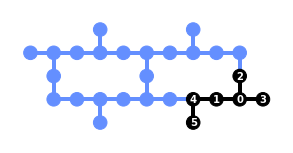

In [68]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(transpiled_vqe_ansatz_for_diff_init[0], backend = backend)

In [ ]:
tcircuits = transpile(vqe_ansatz_for_diff_init, backend = backend, optimization_level = 3)

In [ ]:
tcircuits[0].draw(output = 'mpl')

In [ ]:
tcircuits[0].

### Define the scales ###

In [115]:
#scales = [1, 2.5, 4, 6.5, 8]
scales = [1, 10, 20, 30, 40, 50, 60]

### Get the scaled circuits ###

In [15]:
all_scaled_circs = {} # dictionary of all scaled circuits, the key is the scaling factor
for scale_idx, scale_val in enumerate(scales):
    scaled_circs_for_scale_val = [] # all scaled circuits for the given scaling value
    for c_idx, vqe_circ in enumerate(all_vqe_circuits_transpiled):
        print(scale_val, c_idx)
        scaled_vqe_circ = mitiq.zne.scaling.folding.fold_all(vqe_circ, scale_val)
        scaled_circs_for_scale_val.append(scaled_vqe_circ) # append the scaled circuit to the list
    
    # add to the dictionary
    all_scaled_circs[scale_val] = scaled_circs_for_scale_val

1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
10 24
10 25
10 26
10 27
10 28
10 29
10 30
10 31
10 32
10 33
10 34
10 35
10 36
10 37
10 38
10 39
10 40
10 41
10 42
10 43
10 44
10 45
10 46
10 47
10 48
10 49
10 50
10 51
10 52
10 53
10 54
10 55
10 56
10 57
10 58
10 59
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
20 10
20 11
20 12
20 13
20 14
20 15
20 16
20 17
20 18
20 19
20 20
20 21
20 22
20 23
20 24
20 25
20 26
20 27
20 28
20 29
20 30
20 31
20 32
20 33
20 34
20 35
20 36
20 37
20 38
20 39
20 40
20 41
20 42
20 43
20 44
20 45
20 46
20 47
20 48
20 49
20 50
20 51
20 52
20 53
20 54
20 55
20 56
20 57
20 58
20 59
30 0
30 1


In [16]:
length_list = len(all_scaled_circs[1][0])

for el in all_scaled_circs:
    scaled_circs_list = all_scaled_circs[el]
    for circuit in scaled_circs_list:
        print(el, circuit.depth())

1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
1 43
1 43
1 42
1 42
1 43
1 42
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
10 379
10 379
10 370
10 370
10 379
10 370
20 883
20 883
20 862
20 862
20 883
20 862
20 883
20 883
20 862
20 862
20 883
20 862
20 883
20 883
20 862
20 862
20 883
20 862
20 883
20 883
20 862
20 862
20 883
20 862
20 883
20 883
20 862
20 862
20 883
20 862
20 883
20 883
20 862
20 862
20 883
20 862
20 883
20 883
20 862
20 862


In [17]:
def ibmq_executor(circuits, backend, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    
    max_experiments = backend.configuration().max_experiments
    num_jobs = int(np.ceil(len(circuits)/max_experiments))
    
    all_jobs = []
    for job_idx in range(num_jobs):
        circs_for_job = circuits[job_idx*max_experiments:(job_idx+1)*max_experiments]
        job = qiskit.execute(
            circs_for_job,
            backend=backend,
            optimization_level=0,
            shots=shots
        )
        all_jobs.append(job)
    
    # check if all jobs have been completed or not
    while True:
        combined_job_status = True
        for j in all_jobs:
            combined_job_status = combined_job_status and (str(j.status()) == 'JobStatus.DONE')
        
        if combined_job_status:
            break
    
    # combine all the results from all jobs
    all_counts = []
    for job in all_jobs:
        all_counts = all_counts + job.result().get_counts()
    
    # Convert raw measurement counts to expectation values
    all_expectation_vals = []
    for count in all_counts:
        sum_counts = sum(list(counts.values()))
        exp_val = 0
        for el in count:
            
            # allot the sign to the element
            sign = 1
            if el.count('1')%2 == 1:
                sign = -1
            
            # add to expectation value
            exp_val += sign*(count[el]/sum_counts)
        
        all_expectation_vals.append(exp_val)
            
    return all_expectation_vals

def job_sender(circuits, backend, shots):
    
    max_experiments = backend.configuration().max_experiments
    num_jobs = int(np.ceil(len(circuits)/max_experiments))
    simulator = Aer.get_backend('qasm_simulator')
    
    all_jobs = []
    for job_idx in range(num_jobs):
        circs_for_job = circuits[job_idx*max_experiments:(job_idx+1)*max_experiments]
        job = qiskit.execute(
            circs_for_job,
            backend=backend,
            optimization_level=0,
            shots=shots
        )
        all_jobs.append(job)
    
    return all_jobs

def job_sender_noise_model(circuits, backend, shots):
    
    
    noise_model = NoiseModel.from_backend(backend)
    simulator = Aer.get_backend('qasm_simulator')
    all_jobs = []
    
    job = qiskit.execute(
        circuits,
        backend=simulator,
        noise_model=noise_model,
        optimization_level=0,
        shots=shots
    )
    
    all_jobs.append(job)

    return all_jobs
    
def expectation_calculator(all_jobs, shots_per_circ):
    
    # check if all jobs have been completed or not
    while True:
        combined_job_status = True
        for j in all_jobs:
            combined_job_status = combined_job_status and (str(j.status()) == 'JobStatus.DONE')
        
        if combined_job_status:
            break
    
    # combine all the results from all jobs
    all_counts = []
    for job in all_jobs:
        job_length = len(job.result().results)
        for count_idx in range(job_length):
            try:
                all_counts.append(job.result().get_counts(count_idx))
            except:
                print('Exception encountered!')
                all_counts.append({n_qubits*'0':shots_per_circ})
    
    # Convert raw measurement counts to expectation values
    all_expectation_vals = []
    for idx, count in enumerate(all_counts): 
        sum_counts = sum(list(count.values()))
        exp_val = 0
        for el in count:
            
            # allot the sign to the element
            sign = 1
            if el.count('1')%2 == 1:
                sign = -1
            
            # add to expectation value
            exp_val += sign*(count[el]/sum_counts)
        
        all_expectation_vals.append(exp_val)
            
    return all_expectation_vals

### Unroll the scaled circuits to execute on the processor ###

In [18]:
#unrolling all circuits to submit jobs

all_scaled_circuits_unrolled = []
for scaling_factor in all_scaled_circs:
    all_scaled_circuits_unrolled += all_scaled_circs[scaling_factor]

In [ ]:
paulis

In [19]:
all_jobs = job_sender(all_scaled_circuits_unrolled, backend, 100000)

In [21]:
all_exps = expectation_calculator(all_jobs, 100000)

In [39]:
all_jobs2 = job_sender(all_scaled_circuits_unrolled, backend, 100000)
all_exps2 = expectation_calculator(all_jobs2, 100000)

In [22]:
all_counts = []
for job in all_jobs:
    job_length = len(job.result().results)
    for count_idx in range(job_length):
        try:
            all_counts.append(job.result().get_counts(count_idx))
        except:
            print('Exception encountered!')
            all_counts.append({n_qubits*'0':100000})

In [40]:
all_counts2 = []
for job in all_jobs2:
    job_length = len(job.result().results)
    for count_idx in range(job_length):
        try:
            all_counts2.append(job.result().get_counts(count_idx))
        except:
            print('Exception encountered!')
            all_counts2.append({n_qubits*'0':100000})

### Methods to reorganize the expectation values ###

In [25]:
def get_scaled_exp_dict_list1(num_inits, scales, paulis, all_exps):
    '''
    Args:
    num_inits: The number of initializations
    scales: Different values by which noise is scaled
    paulis: All paulis which are part of the VQE hamiltonian
    all_exps: all expectation values obtained as a list (len(all_exps) = len(scales)*num_inits*len(paulis))
    '''
    
    assert (len(all_exps) == len(scales)*num_inits*len(paulis))
    
    num_elements_per_scale_val = len(scales)
    scaled_exps_dict_list = [{p:[] for p in paulis} for _ in range(num_inits)]

    # number of elements for each scaling value
    length_per_scale = len(all_exps)/num_elements_per_scale_val
    assert (int(length_per_scale) == length_per_scale)
    length_per_scale = int(length_per_scale)

    # scan through all initializations
    for i in range(len(scales)):
        all_scale_i_vals = all_exps[i*length_per_scale:(i+1)*length_per_scale]

        # number of elements per initialization
        num_els_per_init = len(all_scale_i_vals)/num_inits
        assert (int(num_els_per_init) == num_els_per_init)
        num_els_per_init = int(num_els_per_init)

        for j in range(num_inits):
            all_scale_i_vals_j_init = all_scale_i_vals[j*num_els_per_init:(j+1)*num_els_per_init]
            assert len(all_scale_i_vals_j_init) == len(paulis)
            for pidx, pauli in enumerate(paulis):
                scaled_exps_dict_list[j][pauli].append(all_scale_i_vals_j_init[pidx])
    
    return scaled_exps_dict_list

In [26]:
def get_scaled_exp_dict_list2(num_inits, scales, paulis, all_exps):
    '''
    Args:
    num_inits: The number of initializations
    scales: Different values by which noise is scaled
    paulis: All paulis which are part of the VQE hamiltonian
    all_exps: all expectation values obtained as a list (len(all_exps) = len(scales)*num_inits*len(paulis))
    '''
    
    assert (len(all_exps) == len(scales)*num_inits*len(paulis))

    # each element in the list is the scaled expectations dict for a different initilization
    # each scaled expectations dict consists of a list of scaled expectation values indexed 
    scaled_exps_dict_list = []

    all_exp_reshaped = np.array(all_exps).reshape(len(scales), num_inits, -1)
    print(all_exp_reshaped.shape)

    for i in range(num_inits):
        scaled_exps_dict = {el:[] for el in paulis}
        for j in range(len(scales)):
            for p_idx, p in enumerate(paulis):
                scaled_exps_dict[p].append(all_exp_reshaped[j][i][p_idx])

        scaled_exps_dict_list.append(scaled_exps_dict)
    
    return scaled_exps_dict_list

### Save the circuit ###

In [ ]:
parent_folder = '/Users/sid/Internship Project/ZNE experiments/Experiment 1, 2/'
device_name = 'fake_mumbai'
date = '06072023'

In [ ]:
# save all the circuits
pickle.dump(all_init_points, open(parent_folder + device_name + '/' + 'all_init_points_' + date + '_.pkl', 'wb'))
pickle.dump(all_vqe_circuits, open(parent_folder + device_name + '/' + 'all_vqe_circuits_' + date + '_.pkl', 'wb'))
pickle.dump(all_vqe_circuits_transpiled, open(parent_folder + device_name + '/' + 'all_vqe_circuits_transpiled_' + date + '_.pkl', 'wb'))

In [ ]:
pickle.dump(all_scaled_circs, open(parent_folder + device_name + '/' + 'all_scaled_circs_' + date + '_.pkl', 'wb'))

In [ ]:
pickle.dump(all_counts, open(parent_folder + device_name + '/' + 'all_counts_' + date + '_.pkl', 'wb'))

In [ ]:
pickle.dump(all_exps, open(parent_folder + device_name + '/' + 'all_exps_' + date + '_.pkl', 'wb'))

### Visualize the extrapolation curves ###

In [ ]:
scaled_circs_loaded = pickle.load(open(parent_folder + device_name + '/' + 'all_scaled_circs_' + date + '_.pkl', 'rb'))

In [ ]:
all_exps = pickle.load(open(parent_folder + device_name + '/' + 'CH4-AS3-1/all_exps_' + date + '_.pkl', 'rb'))

In [27]:
scaled_exps_dict_list = get_scaled_exp_dict_list1(10, scales, paulis, all_exps)

In [41]:
scaled_exps_dict_list2 = get_scaled_exp_dict_list1(10, scales, paulis, all_exps2)

In [ ]:
scales = [1, 10, 20, 30, 40, 50, 60]

In [37]:
paulis

['XXIYXY', 'XXIYYX', 'XYYIZI', 'XYYIZZ', 'XYIYXX', 'XZXIII']

XZXIII


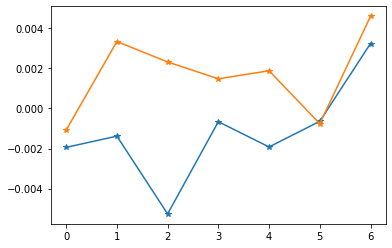

In [47]:
i = 0 # initialization index (different indices correpond to different initialization points)
p0 = 5 # index
print(paulis[p0])
plt.plot(list(range(len(scales))), scaled_exps_dict_list[i][paulis[p0]], marker = '*')
plt.plot(list(range(len(scales))), scaled_exps_dict_list2[i][paulis[p0]], marker = '*')
#plt.plot(list(range(len(scales))), scaled_exps_dict_list[i][paulis[p0]], marker = 'd')
#plt.plot(list(range(len(scales))), scaled_exps_dict_list[i][paulis[p1]], marker = 'd')

In [ ]:
all_counts = pickle.load(open(parent_folder + device_name + '/' + 'all_counts_' + date + '_.pkl', 'rb'))

In [ ]:
scaled_counts_dict_list = get_scaled_exp_dict_list1(10, scales, paulis, all_counts)

In [ ]:
i = 0
p0 = 21
print(paulis[p0])
plot_histogram(scaled_counts_dict_list[i][paulis[p0]][6])

In [ ]:
all_vqe_circuits_transpiled = pickle.load(open(parent_folder + device_name + '/' + 'all_vqe_circuits_transpiled_' + date + '_.pkl', 'rb'))

In [ ]:
relevant_circuit = all_vqe_circuits_transpiled[10*i + p0]

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
ideal_counts = execute(relevant_circuit, backend = simulator, shots = 8192).result().get_counts()
plot_histogram(ideal_counts)

In [ ]:
# try out the richardson extrapolation and get the parameters

from mitiq.zne.inference import ExpFactory, AdaExpFactory

rf = RichardsonFactory(scale_factors = scales)
ef = ExpFactory(scale_factors = scales)
aef = AdaExpFactory(steps = len(scales), scale_factor = 10)

i = 3
scaled_counts = scaled_exps_dict_list[i]
all_params = {}
for pauli in paulis:
    counts = scaled_counts[pauli]
    params_pauli = aef.extrapolate(scales, counts, full_output = True)
    all_params[pauli] = params_pauli

dim = len(list(all_params.values())[0][2])
all_params_array = np.zeros((len(paulis), dim))

for idx, pauli in enumerate(paulis):
    all_params_array[idx] = np.array(all_params[pauli][2])

import scipy.cluster.hierarchy as hcluster
thresh = 0.1
clusters = hcluster.fclusterdata(all_params_array, thresh, criterion="distance")

# plotting
# plt.scatter(*np.transpose(all_params_array), c=clusters)
# plt.axis("equal")
# title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
# plt.title(title)
# plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE()
new_array = tsne.fit_transform(all_params_array)

In [ ]:
plt.scatter(new_array[:, 0], new_array[:, 1])

In [ ]:
paulis

In [ ]:
all_params['XXXZII'][-1](0)

In [ ]:
all_params['XXIYXY']

In [ ]:
all_counts = []
for job in all_jobs:
    all_counts += job.result().get_counts()

hop = len(paulis)*num_inits
i = 1
relevant_counts = []
for kk in range(len(scales)):
    relevant_counts.append(all_counts[i + kk*hop])
#plot_histogram(relevant_counts)

In [ ]:
all_exps = compute_expectations(relevant_counts)

In [ ]:
plt.plot(list(range(len(all_exps))), all_exps, marker = 'd')

In [ ]:
from qiskit.quantum_info.operators import Operator, Pauli

In [ ]:
print(Operator(Pauli('ZZZ')))

### Do the spectral norm analysis ###

In [ ]:
for i in range(len(paulis)):
    for j in range(i, len(paulis)):
        
        pauli_i = paulis[i]
        pauli_j = paulis[j]
        norm_val = np.linalg.norm(op_matrices[i].data - op_matrices[j].data, ord = 2)
        print(pauli_i, pauli_j, norm_val)

### IBM backend analysis ###

In [ ]:
provider = IBMProvider()
backend = provider.get_backend('ibm_algiers')

In [ ]:
relevant_paulis = [paulis[2], paulis[3], paulis[5], paulis[7], paulis[11], n_qubits*'Z']

In [ ]:
job = provider.backend.retrieve_job('cifg8f460l54kv9qorn0')

In [ ]:
scales = [1, 2.5, 4, 6.5, 8]

In [ ]:
all_exps = expectation_calculator([job])

In [ ]:
scaled_exps_dict_list = get_scaled_exp_dict_list1(10, scales, relevant_paulis, all_exps)

In [ ]:
i = 8 # initialization index (different indices correpond to different initialization points)
p0 = 0 # index
print(relevant_paulis[p0])
plt.plot(list(range(len(scales))), scaled_exps_dict_list[i][relevant_paulis[p0]], marker = '*')